In [1]:
import os 
import pandas as pd
pd.set_option('display.max_columns', None)
import subprocess
import glob
import pybedtools as pbt 
pbt.set_tempdir('/mnt/hpcscratch/jreyna/')
pbt.set_bedtools_path('/mnt/BioApps/bedtools/bin/')
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt 

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

genome_sizes = 'results/refs/hg19/hg19.chrom.sizes'

# make the directory to save our data
outdir = 'results/main/pieqtls/sgl_intersect/'
os.makedirs(outdir, exist_ok=True)

In [2]:
gs_fn = 'results/refs/hg19/hg19.chrom.nochr.sizes'
gencode_fn = 'results/refs/gencode/v30/gencode.v30.annotation.bed'
gencode = pd.read_table(gencode_fn, header=None)
gencode = gencode.drop_duplicates(5)
gencode_dict = {k:v for k,v in gencode[[5,6]].values.tolist()} 
gencode_dict.update({v:k for k,v in gencode[[5,6]].values.tolist()})

## Load Significant GWAS

In [3]:
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton']

In [4]:
data = []
gwas = 'results/main/coloc/Data/T1D_GWAS/*/GRCh37/GWAS_input_colocalization_pval_lt_5eMinus8.txt'
for fn in glob.glob(gwas):
    path_info = fn.split('/')
    df = pd.read_table(fn)
    
    if path_info[5] not in major_gwas:
        continue
        
    df['gwas_source'] = path_info[5]
    data.append(df)    
gwas_df = pd.concat(data)
gwas_df['sid'] = gwas_df['CHR'].str.replace('chr', '') + ':' + gwas_df['POS'].astype(str)

# loading finemap data into bedtools
gwas_bed = gwas_df.iloc[:, [0,1,1]]
gwas_bed.columns = ['chrom', 'start', 'end']
gwas_bed['start'] = gwas_bed['start'] - 1
gwas_pbt = pbt.BedTool.from_dataframe(gwas_bed)

/mnt/hpcscratch/jreyna//ipykernel_75129/915015123.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_bed['start'] = gwas_bed['start'] - 1


In [5]:
individual_gwas_studies = gwas_df.groupby('gwas_source').sid.nunique()
individual_gwas_studies = individual_gwas_studies.to_frame()
individual_gwas_studies.columns = ['Number of Sig. GWAS']

In [6]:
individual_gwas_studies

,Number of Sig. GWAS
gwas_source,
T1D_32005708,21097
T1D_34012112_Gaulton,45798
T1D_34594039_GCST90018925,20419


## Load pieQTLs

In [7]:
pieqtls = glob.glob('results/main/pieqtls/2021_chandra_et_al/*/proximal.pieqtls.tsv')

pieqtl_data = []
for pieqtl in pieqtls:
    print(pieqtl)
    
    cline = pieqtl.split('/')[-2]
    df = pd.read_table(pieqtl)    
    df['cline'] = cline
    pieqtl_data.append(df) 
    
pieqtl_df = pd.concat(pieqtl_data)
pieqtl_df['Chromosome'] = pieqtl_df['Chromosome']
pieqtl_df.loc[:, 'sid'] = pieqtl_df['Chromosome'].str.replace('chr', '') + ':' + \
                          pieqtl_df['pieQTL.Position'].astype(str)

results/main/pieqtls/2021_chandra_et_al/B-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/NK-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/monocyte_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/CD4_T-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/CD8_T-cell_naive/proximal.pieqtls.tsv


In [8]:
individual_cells = pieqtl_df.groupby('cline').Target_geneID.nunique()
individual_cells = individual_cells.to_frame()
individual_cells.columns = ['Number of pieQTL Genes']
individual_cells

,Number of pieQTL Genes
cline,
B-cell_naive,1233
CD4_T-cell_naive,1168
CD8_T-cell_naive,1081
NK-cell_naive,872
monocyte_naive,1065


In [9]:
individual_cells = pieqtl_df.groupby('cline').sid.nunique()
individual_cells = individual_cells.to_frame()
individual_cells.columns = ['Number of pieQTL SNPs']
individual_cells

,Number of pieQTL SNPs
cline,
B-cell_naive,8110
CD4_T-cell_naive,6800
CD8_T-cell_naive,5539
NK-cell_naive,5332
monocyte_naive,6006


In [10]:
pieqtl_bed = pieqtl_df.iloc[:, [1,2,2,-1]]
pieqtl_bed.columns = ['chrom', 'start', 'end', 'cline']
pieqtl_bed.loc[:, 'start'] = pieqtl_bed['start'] - 1
pieqtl_pbt = pbt.BedTool.from_dataframe(pieqtl_bed)

/mnt/hpcscratch/jreyna//ipykernel_75129/2754423286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pieqtl_bed.loc[:, 'start'] = pieqtl_bed['start'] - 1


In [11]:
pieqtl_bed.shape

(35898, 4)

## Intersect pieQTLs and Sig GWAS

In [12]:
major_cols = ['ge_source',
              'rsid',
             'chrom',
             'pos',
             'geneid',
             'genename',
             'allele1',
             'allele2',
             'maf',
             'beta_x',
             'se',
             'z',
             'prob',
             'log10bf',
             'mean',
             'sd',
             'mean_incl',
             'sd_incl',
             'pval',
             'gwas_source',
             'pieQTL.ID',
             'Chromosome',
             'pieQTL.Position',
             'Target_geneName',
             'TSS',
             'pvalue',
             'FDR (DICE)',
             'beta_y',
             'ref',
             'alt',
             'Mean.TPM.Homozygous.Reference',
             'Mean.TPM.Heterozygous',
             'Mean.TPM.Homozygous.Alternative',
             'Interaction_type',
             'GWAS.Trait',
             'cline',
             'regionID',
             'GWASLoci',
             'index']


### Intersection

In [13]:
intersect_df = pd.merge(gwas_df, pieqtl_df,
                        left_on=['CHR', 'POS'],
                        right_on=['Chromosome', 'pieQTL.Position'],
                        how='inner')

In [14]:
indiv_cell_intersect = intersect_df.groupby('cline').Target_geneID.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique Genes from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

,Number of Unique Genes from pieQTL & Sig.GWAS Intersection
cline,
B-cell_naive,39
CD4_T-cell_naive,33
CD8_T-cell_naive,35
NK-cell_naive,45
monocyte_naive,25


In [15]:
indiv_cell_intersect = intersect_df.groupby('cline').sid_x.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique SNPs from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

,Number of Unique SNPs from pieQTL & Sig.GWAS Intersection
cline,
B-cell_naive,348
CD4_T-cell_naive,322
CD8_T-cell_naive,269
NK-cell_naive,319
monocyte_naive,116


In [16]:
indiv_cell_intersect = intersect_df.groupby(['cline', 'gwas_source']).Target_geneID.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique Genes from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

Number of Unique Genes from pieQTL & Sig.GWAS Intersection
cline            gwas_source                                                                          
B-cell_naive     T1D_32005708                                                              28         
                 T1D_34012112_Gaulton                                                      34         
                 T1D_34594039_GCST90018925                                                 21         
CD4_T-cell_naive T1D_32005708                                                              15         
                 T1D_34012112_Gaulton                                                      29         
                 T1D_34594039_GCST90018925                                                 14         
CD8_T-cell_naive T1D_32005708                                                              18         
                 T1D_34012112_Gaulton                                                      30         
                 T1D_34594039_GCST90018925                                                 15         
NK-cell_naive    T1D_32005708                                                              34         
                 T1D_34012112_Gaulton                                                      36         
                 T1D_34594039_GCST90018925                                                 17         
monocyte_naive   T1D_32005708                                                              14         
                 T1D_34012112_Gaulton                                                      22         
                 T1D_34594039_GCST90018925                                                  8

In [17]:
indiv_cell_intersect = intersect_df.groupby(['cline', 'gwas_source']).sid_x.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique SNPs from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

Number of Unique SNPs from pieQTL & Sig.GWAS Intersection
cline            gwas_source                                                                         
B-cell_naive     T1D_32005708                                                             186        
                 T1D_34012112_Gaulton                                                     241        
                 T1D_34594039_GCST90018925                                                116        
CD4_T-cell_naive T1D_32005708                                                             142        
                 T1D_34012112_Gaulton                                                     198        
                 T1D_34594039_GCST90018925                                                 53        
CD8_T-cell_naive T1D_32005708                                                             136        
                 T1D_34012112_Gaulton                                                     155        
                 T1D_34594039_GCST90018925                                                 73        
NK-cell_naive    T1D_32005708                                                             171        
                 T1D_34012112_Gaulton                                                     175        
                 T1D_34594039_GCST90018925                                                 77        
monocyte_naive   T1D_32005708                                                              82        
                 T1D_34012112_Gaulton                                                      76        
                 T1D_34594039_GCST90018925                                                 33

In [18]:
def get_genename(x):
    if x in gencode_dict:
        return(gencode_dict[x])
    else:
        return(x)

In [19]:
intersect_df.loc[:, 'geneid'] = intersect_df['Target_geneID'].str.replace('\.[0-9]*', '', regex=True)
intersect_df.loc[:, 'genename'] = intersect_df.loc[:, 'geneid'].apply(get_genename)

In [20]:
intersect_df.loc[:, 'geneid'].nunique()

91

In [21]:
for x in intersect_df.genename.unique():
    print(x)

C1orf216
SF3A3
FHL3
PTPN22
RGS1
NPM1P33
KRT18P39
CD28
SLC22A5
BTN3A1
BTN2A2
ZSCAN26
ZNF165
AL645939.1
IFITM4P
ZDHHC20P1
ZFP57
AL645929.1
HCG4B
AL671277.2
RNF39
FLOT1
DHX16
PPP1R18
ZNRD1ASP
TRIM26
VARS2
MRPS18B
TUBB
C6orf136
RF00019
PRRC2A
BAG6
CCHCR1
CSNK2B
C6orf47
TCF19
HCG27
AL662844.3
AL662844.4
MICB
MICA
AL645933.2
LST1
NCR3
LY6G5B
LY6G5C
C6orf48
AIF1
MSH5
PPT2
SKIV2L
BTNL2
ENSG00000228962
TSBP1
HCG24
TAP2
WDR46
PFDN6
RPL32P1
BACH2
AP003774.4
M6PR
LINC02390
SUOX
ATXN2
TMEM116
HECTD4
MAPKAPK5
CTSH
AC009121.1
RMI2
DND1P1
KANSL1-AS1
AP005482.1
ZGLP1
PRKD2
TMPRSS3
ZSCAN9
TRIM27
ENSG00000261353
BTN2A3P
ZKSCAN4
BTN2A1
BTN3A2
HMGN4
HCG18
GNL1
ZSCAN23
ZNF192P1


## Summarize

In [22]:
# find the unique SNPs
uniq_snps_by_cells = intersect_df.groupby('cline').sid_x.nunique()
uniq_snps_by_cells = uniq_snps_by_cells.to_frame()

# find the unique genes 
uniq_genes_by_cells = intersect_df.groupby('cline').geneid.nunique()
uniq_genes_by_cells = uniq_genes_by_cells.to_frame()

# merge snps and genes
uniq_counts_by_cells = pd.merge(uniq_snps_by_cells, uniq_genes_by_cells, left_index=True, right_index=True)
uniq_counts_by_cells.columns = ['Number of Unique SNPs', 'Number of Unique Genes']
uniq_counts_by_cells.index.name = 'Cell Line'

In [23]:
# save the file
excel_analysis = os.path.join(outdir, 'Unique_Counts_By_Cell_Line.xlsx')
uniq_counts_by_cells.to_excel(excel_analysis, sheet_name='pieqtls')

In [24]:
uniq_genes_by_cells

,geneid
cline,
B-cell_naive,39
CD4_T-cell_naive,33
CD8_T-cell_naive,35
NK-cell_naive,45
monocyte_naive,25


In [25]:
excel_analysis

'results/main/pieqtls/sgl_intersect/Unique_Counts_By_Cell_Line.xlsx'

#### Write the gene list as well

In [26]:
gh_list = sorted(intersect_df.geneid.unique().tolist())
gh_fn = os.path.join(outdir, 'gene_list.txt')
with open(gh_fn, 'w') as fw:
    for x in gh_list:
        fw.write('{}\n'.format(x))

In [27]:
gh_list = sorted(intersect_df.geneid.unique().tolist())

In [28]:
len(gh_list)

91

In [29]:
intersect_df[['cline', 'geneid']]

,cline,geneid
0,monocyte_naive,ENSG00000142686
1,NK-cell_naive,ENSG00000183431
2,CD4_T-cell_naive,ENSG00000183386
3,CD8_T-cell_naive,ENSG00000183386
4,NK-cell_naive,ENSG00000183431
...,...,...
2137,CD4_T-cell_naive,ENSG00000271821
2138,CD4_T-cell_naive,ENSG00000206344
2139,CD4_T-cell_naive,ENSG00000271821
2140,NK-cell_naive,ENSG00000206344


#### Get the unique genes per cell type 

In [30]:
genes_by_cell = intersect_df[['cline', 'geneid']].drop_duplicates()
genes_by_cell.sort_values(['cline', 'geneid'], inplace=True)
genes_by_cell['source'] = 'pieqtls_with_sig_gwas'
genes_by_cell.columns = ['cline', 'geneid', 'source']
fn = os.path.join(outdir, 'genes_by_cell.xlsx')
genes_by_cell.to_excel(fn, index=False)

#### Make a figure of uniq SNPs and Genes per cell

In [35]:
color_fn = 'results/refs/dice_colors/colors.revised.t1d-project.tsv'
colors = pd.read_table(color_fn)
cline_pubnames = {'CD4_T-cell_naive': 'CD4 T-cells', 'CD8_T-cell_naive': 'CD8 T-cells',
                  'monocyte_naive': 'Monocytes', 'B-cell_naive': 'B-cells', 'NK-cell_naive': 'NK cells'}
colors_dict = {sr.studyname: sr.hex for i, sr in colors.iterrows()}

In [36]:
uniq_counts_by_cells['pubnames'] = uniq_counts_by_cells.index.map(cline_pubnames)

In [39]:
uniq_counts_by_cells.sort_values('pubnames', inplace=True)

In [40]:
uniq_counts_by_cells

,Number of Unique SNPs,Number of Unique Genes,pubnames
Cell Line,,,
B-cell_naive,348,39,B-cells
CD4_T-cell_naive,322,33,CD4 T-cells
CD8_T-cell_naive,269,35,CD8 T-cells
monocyte_naive,116,25,Monocytes
NK-cell_naive,319,45,NK cells


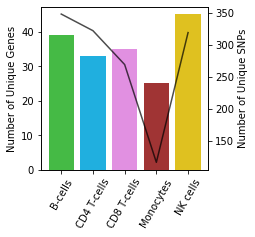

In [41]:
fig, ax = plt.subplots(figsize=(3,3))


sns.barplot(x='pubnames', y='Number of Unique Genes', palette=colors_dict, data=uniq_counts_by_cells, dodge=False)

ax.set_xlabel('')
ax.set_xticklabels(uniq_counts_by_cells['pubnames'], rotation = 60)

ax2 = ax.twinx()
sns.lineplot(x='pubnames', y='Number of Unique SNPs', data=uniq_counts_by_cells, color='#000000B3', ax=ax2)

sgl_summary_fn = os.path.join(outdir, 'sgls_pieqtls_with_sig_gwas_summary.svg')
fig.savefig(sgl_summary_fn)

## Save a unique list of SNPs within an SGL

In [82]:
gwas_grps = intersect_df.groupby('gwas_source')
for gwas_source, gwas_df in gwas_grps:
    
    uniq_sids = gwas_df.sid_x.drop_duplicates().sort_values()
    uniq_sids = uniq_sids.str.replace(':', '-')
    
    fn = os.path.join(outdir, 'pieqtls_sgls.{}.tsv'.format(gwas_source))
    uniq_sids.to_csv(fn, header=False, index=False)

In [105]:
intersect_df.sid_x.nunique()

868

## Check Out SNPs

In [ ]:
intersect_df.head(4)

In [ ]:
intersect_df.loc[intersect_df.genename == 'RPS62']

In [ ]:
intersect_df.loc[intersect_df.geneid == 'ENSG00000170485']

In [ ]:
high = ['SF3A3',
 'PTPN22',
 'RGS1',
 'CTLA4',
 'SLC22A5',
 'BTN3A2',
 'BTN2A2',
 'BTN3A1',
 'BTN2A1',
 'ZKSCAN4',
 'TRIM27',
 'ZFP57',
 'TRIM26',
 'MRPS18B',
 'FLOT1',
 'VARS2',
 'MICA',
 'NCR3',
 'BAG6',
 'TSBP1',
 'BTNL2',
 'TAP2',
 'WDR46',
 'BACH2',
 'IL2RA',
 'RBM17',
 'M6PR',
 'SUOX',
 'RPS26',
 'CUX2',
 'ATXN2',
 'NAA25',
 'CTSH',
 'RMI2',
 'ZPBP2',
 'GSDMB',
 'ORMDL3',
 'VASP',
 'PRKD2',
 'IL2RB',
 'RAC2',
 'MFNG']

In [ ]:
high_df = intersect_df.loc[(intersect_df.genename.isin(high)) & (intersect_df.Interaction_type == 'Direct_pieQTL')]

In [ ]:
for rs in sorted(set(high_df['pieQTL.ID'].tolist())):
    print(rs)

In [ ]:
intersect_df

## Intersect PC-HiC with HiChIP Loops

In [ ]:
pieqtls_sgls_fn = os.path.join(outdir, 'pieqtls_sgls.tsv')
intersect_df.to_csv(pieqtls_sgls_fn, sep='\t', index=False)

In [ ]:
pieqtls_sgls_fn

In [ ]:
intersect_df.loc[intersect_df.sid_x == '6:28863264']

In [ ]:
intersect_df.value_counts('gwas_source')

In [ ]:
intersect_df.sid_x.nunique()

## Characterizing SNPs within an SGL

In [42]:
#loading Vu et al 2022 chromHMM annotations 
chromhmm = pd.read_table('results/refs/chromHMM/vu_et_al_2022/hg38lift_genome_100_segments.bed.gz', 
                         header=None)
chromhmm_pbt = pbt.BedTool.from_dataframe(chromhmm)

In [51]:
chromhmm

,0,1,2,3
0,chr1,10000,10400,1_GapArtf2
1,chr1,10400,10600,26_Acet1
2,chr1,10600,10800,37_EnhWk4
3,chr1,10800,12800,0_GapArtf1
4,chr1,12800,13000,37_EnhWk4
...,...,...,...,...
6099633,chrY,56886253,56886453,12_HET5
6099634,chrY,56886453,56886853,1_GapArtf2
6099635,chrY,56886853,56887053,12_HET5
6099636,chrY,56887053,56887253,13_HET6


In [52]:
finemapping_pbt = intersect_df[['Chromosome', 'pieQTL.Position', 'pieQTL.Position']].drop_duplicates()
#finemapping_pbt.iloc[:, 0] = 'chr' + finemapping_pbt.iloc[:, 0].astype(str)
finemapping_pbt.iloc[:, 1] = finemapping_pbt.iloc[:, 1] - 1 # convert to bed format 
finemapping_pbt = pbt.BedTool.from_dataframe(finemapping_pbt)

In [53]:
finemapping_chromhmm = finemapping_pbt.intersect(chromhmm_pbt, loj=True, wa=True)
finemapping_chromhmm = finemapping_chromhmm.to_dataframe()
finemapping_chromhmm.columns = ['chr', 'start', 'end', 'chr2', 'chmm_start', 'chmm_end', 'state']

# extract the statename without the id number
def split_chromhmm(x):
    s = x.split('_')
    if len(s) > 1:
        return(s[1])
    else:
        return('None')
finemapping_chromhmm['state_name'] = finemapping_chromhmm.state.map(split_chromhmm)

# add the major state which removes the subtypes
finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')

/mnt/hpcscratch/jreyna//ipykernel_75129/3274623952.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')


In [54]:
state_dict = {'Quies': 'Quiescent',
             'ReprPC': 'Repressor',
             'GapArtf': 'No signal, unmappable',
             'Acet': 'Acetylation',
             'TxWk': 'Weak transcription',
             'EnhWk': 'Weak enhancer',
             'None': 'No overlap',
             'Tx': 'Transcription',
             'EnhA': 'Enhancer',
             'TxEx': 'Transcription & Exons',
             'HET': 'H3K9me3 & LTR repeats',
             'TxEnh': 'Transcription & Enhancers',
             'BivProm': 'Bivalent Promoters',
             'znf': 'Zinc Finger',
             'PromF': 'Downstream Promoter',
             'DNase': 'DNase',
             'TSS': 'TSS'}

state_colors = {'Quies': 'grey',
             'ReprPC': 'grey',
             'GapArtf': 'grey',
             'Acet': 'grey',
             'None': 'grey',
             'HET': 'grey',
             'EnhWk': 'lightYellow',
             'EnhA': 'yellow',
             'TxWk': 'lightGreen',
             'Tx': 'darkgreen',
             'TxEx': 'darkgreen',
             'TxEnh': 'darkgreen',
             'DNase': 'blue',
             'znf': 'blue', 
             'BivProm': 'red',
             'PromF': 'red',
             'TSS': 'red'}

fm_state_cnts = finemapping_chromhmm.major_state.value_counts()
fm_state_cnts = fm_state_cnts.to_frame()

In [55]:
fm_state_cnts.columns = ['counts']
fm_state_cnts['major_state'] = fm_state_cnts.index

In [56]:
fm_state_cnts

,counts,major_state
ReprPC,233,ReprPC
EnhA,151,EnhA
Quies,115,Quies
EnhWk,64,EnhWk
TxEx,47,TxEx
TSS,45,TSS
Tx,42,Tx
PromF,33,PromF
TxEnh,31,TxEnh
TxWk,31,TxWk


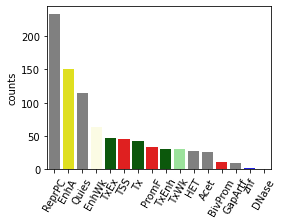

In [80]:
# Ploting the distribution of ALL Fine-mapped SNPs
fig, ax = plt.subplots(figsize=(4,3))

sns.barplot(x='major_state', y='counts', data=fm_state_cnts, hue='major_state', palette=state_colors, dodge=False)

ax.set_xlabel('');
ax.set_xticklabels(fm_state_cnts['major_state'], rotation = 60);

# ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.5, 0.9),
#           fancybox=True, shadow=False)
ax.legend_.set_visible(False)

chromhmm_summary_fn = os.path.join(outdir, 'sgl_pieqtl_snps_characterized_chromhmm.svg')
fig.savefig(chromhmm_summary_fn)

chromhmm_summary_fn = os.path.join(outdir, 'sgl_pieqtl_snps_characterized_chromhmm.png')
fig.savefig(chromhmm_summary_fn)

## Per study

In [108]:
intersect_df.gwas_source.value_counts()

T1D_34012112_Gaulton         945
T1D_32005708                 811
T1D_34594039_GCST90018925    386
Name: gwas_source, dtype: int64

In [110]:
intersect_df[['sid_y', 'geneid', 'cline']].drop_duplicates()

,sid_y,geneid,cline
0,1:36107510,ENSG00000142686,monocyte_naive
1,1:38397341,ENSG00000183431,NK-cell_naive
2,1:38397341,ENSG00000183386,CD4_T-cell_naive
3,1:38397341,ENSG00000183386,CD8_T-cell_naive
4,1:38397369,ENSG00000183431,NK-cell_naive
...,...,...,...
2137,6:31229274,ENSG00000271821,CD4_T-cell_naive
2138,6:31229282,ENSG00000206344,CD4_T-cell_naive
2139,6:31229282,ENSG00000271821,CD4_T-cell_naive
2140,6:31266117,ENSG00000206344,NK-cell_naive
